# Imports

In [1]:
import tensorflow as tf
from tensorflow_probability import edward2 as ed
import numpy as np
import matplotlib.pyplot as plt
import inferpy as inf
from inferpy.data import mnist
import pandas as pd
import sys

import warnings
warnings.filterwarnings("ignore")

/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/hom

# Constants

In [2]:
# Training epochs
num_epochs = 3000
# Learning rate for Adam optimizer
learning_rate = 0.01
# number of observations (dataset size)
N = 1000
# digits considered
DIG = [0,1,2]

tf.set_random_seed(1234)

# Data Samples

MNIST dataset containg handwritten digits will be used. In particular we might obtain the data from the ``inferpy`` package:

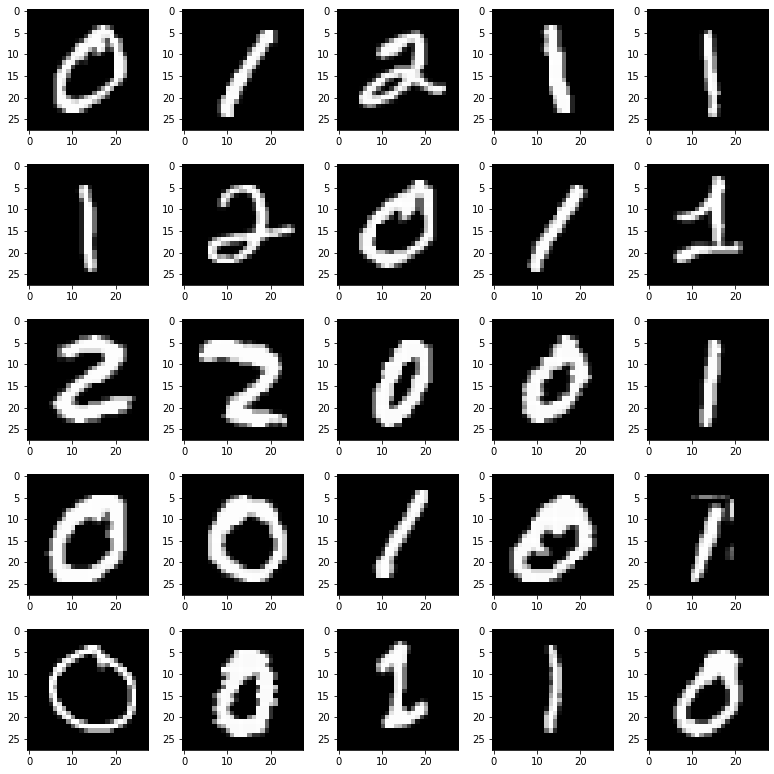

In [3]:
# load the data
(X_train, y_train), _ = mnist.load_data(num_instances=N, digits=DIG)

# plot the digits
mnist.plot_digits(X_train, grid=[5,5])

# Model definition

The input parameters are: $k$ is the latent dimension, $d$ is the data-dimension and $N$ the number of samples or data instances. 

In [4]:
@inf.probmodel
def pca(k,d):
    w = inf.Normal(loc=tf.zeros([k,d]),
                   scale=1, name="w")               # shape = [k,d]
    w0 = inf.Normal(loc=tf.zeros([d]),
                    scale=1, name="w0")             # shape = [d]
    with inf.datamodel():
        z = inf.Normal(tf.zeros([k]),1, name="z")       # shape = [N,k]
        x = inf.Normal( z @ w + w0, 1, name="x")         # shape = [N,d]

This is a latent variable model (LVM) where the latent representation $\boldsymbol{z}$ is known as the scores, and the affine transformation is performed using the loading matrix  $\boldsymbol{\beta}$.

# Variational Model

We define a generative model for sampling from $q(\boldsymbol{\beta},\boldsymbol{z} | \boldsymbol{\lambda}, \boldsymbol{\phi})$, where $\boldsymbol{\lambda}, \boldsymbol{\phi}$ are the variational parameters to optimise.





In [5]:
@inf.probmodel
def Q(k,d):
    qw_loc = inf.Parameter(tf.zeros([k,d]), name="qw_loc")
    qw_scale = tf.math.softplus(inf.Parameter(tf.ones([k,d]), name="qw_scale"))
    qw = inf.Normal(qw_loc, qw_scale, name="w")

    qw0_loc = inf.Parameter(tf.ones([d]), name="qw0_loc")
    qw0_scale = tf.math.softplus(inf.Parameter(tf.ones([d]), name="qw0_scale"))
    qw0 = inf.Normal(qw0_loc, qw0_scale, name="w0")
    
    with inf.datamodel():
        qz_loc = inf.Parameter(np.zeros([k]), name="qz_loc")
        qz_scale = tf.math.softplus(inf.Parameter(tf.ones([k]), name="qz_scale"))
        qz = inf.Normal(qz_loc, qz_scale, name="z")

# Training

In [11]:
# Model constants
k, d = 2, np.shape(X_train)[-1]

# create an instance of the P model and the Q model
m = pca(k,d)
q = Q(k,d)

optimizer = tf.train.AdamOptimizer(learning_rate)
VI = inf.inference.VI(q, optimizer=optimizer, epochs=num_epochs)

In [7]:
m.fit({"x": X_train}, VI)        


 0 epochs	 2874391040.0....................
 200 epochs	 2501561088.0....................
 400 epochs	 1890838528.0....................
 600 epochs	 1654848640.0....................
 800 epochs	 1600215296.0....................
 1000 epochs	 1579120000.0....................
 1200 epochs	 1520809600.0....................
 1400 epochs	 1396713216.0....................
 1600 epochs	 1314570112.0....................
 1800 epochs	 1282795904.0....................

Print loss function evolution

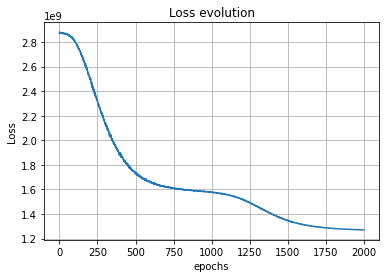

In [8]:
L = VI.losses
plt.plot(range(len(L)), L)

plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss evolution')
plt.grid(True)
plt.show()

# Results

After the inference, we can plot the hidden representation:

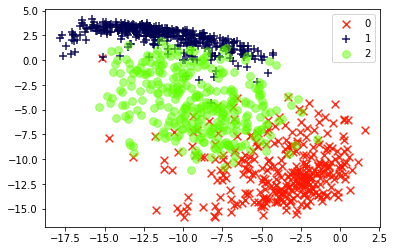

In [9]:
post = {"z": m.posterior("z", data={"x": X_train}).sample()}

markers = ["x", "+", "o"]
colors = [plt.get_cmap("gist_rainbow")(0.05),
          plt.get_cmap("gnuplot2")(0.08),
          plt.get_cmap("gist_rainbow")(0.33)]
transp = [0.9, 0.9, 0.5]

fig = plt.figure()

for c in range(0, len(DIG)):
    col = colors[c]
    plt.scatter(post["z"][y_train == DIG[c], 0], 
                post["z"][y_train == DIG[c], 1], 
                color=col,
                label=DIG[c], 
                marker=markers[c], 
                alpha=transp[c], 
                s=60)
    plt.legend()

We may try to reconstruct the data from the hidden space

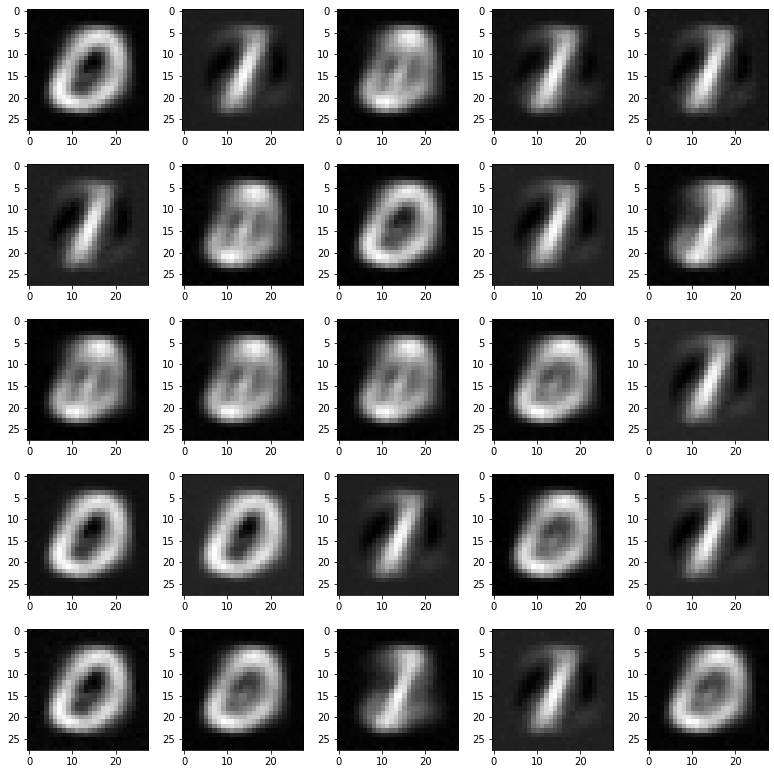

In [10]:
x_gen = m.posterior_predictive('x', data=post).sample()

# plot the digits
mnist.plot_digits(x_gen, grid=[5,5])